# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [2]:
# !pip install kaggle
# !pip install wandb

In [78]:
# import kaggle

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [8]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt


import pandas as pd
from torch.optim import Optimizer
from torch.nn.modules.loss import _Loss
# from tqdm import tqdm
from tqdm.notebook import tqdm
import wandb

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [3]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [4]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
images = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {images} to {download_path}")
    api.dataset_download_files(images, path=download_path, unzip=True)
    print("Download complete!")

Dataset already exists at chest_xray_dataset. Skipping download.


In [5]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Re-split dataset already exists at chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [6]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

{'train': {'NORMAL': 1266, 'PNEUMONIA': 3418}, 'val': {'NORMAL': 158, 'PNEUMONIA': 427}, 'test': {'NORMAL': 159, 'PNEUMONIA': 428}}
Original DataFrame:
   Split      Class  Count
0  train     NORMAL   1266
1  train  PNEUMONIA   3418
2    val     NORMAL    158
3    val  PNEUMONIA    427
4   test     NORMAL    159
5   test  PNEUMONIA    428

Pivoted DataFrame:
   Split  NORMAL  PNEUMONIA
0   test     159        428
1  train    1266       3418
2    val     158        427


array([[<Axes: title={'center': 'NORMAL'}>,
        <Axes: title={'center': 'PNEUMONIA'}>]], dtype=object)

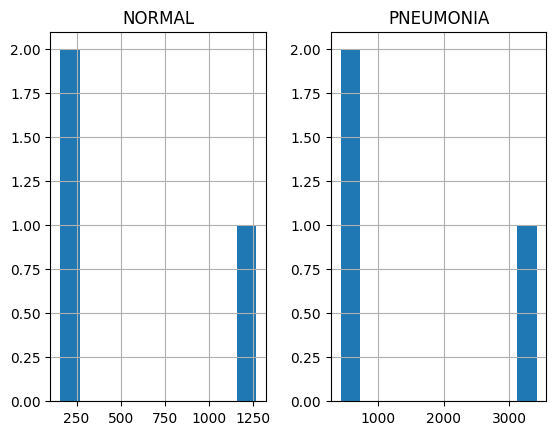

In [9]:
print(stats)

images = []
for split in stats:
    for cls in stats[split]:
        images.append({
            'Split': split,
            'Class': cls,
            'Count': stats[split][cls]
        })

# Create the DataFrame
df = pd.DataFrame(images)

# Optionally, you can pivot the DataFrame for a different view
df_pivot = df.pivot(index='Split', columns='Class', values='Count').reset_index()
df_pivot.columns.name = None  # Remove the columns name

# Print both DataFrames
print("Original DataFrame:")
print(df)
print("\nPivoted DataFrame:")
print(df_pivot)
df_pivot.hist()

**(a)**

_Insert brief discussion of analysis here_

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [10]:
dataset_path = "chest_xray_dataset_new_split"
BATCH_SIZE: int = 32

In [11]:
from typing import Dict, List, Optional, Tuple, Union

import torchvision

class ChestXrayDataset(Dataset):
    """Chest Xray Dataset Loader"""
    def __init__(self, root_dir: str, split: str, transform: torchvision.transforms.Compose = None):
        """Provide the root dir to the dataset and the specified split"""
        super().__init__()        
        self.root_dir: str = root_dir
        #TODO Move label assingment here instead of __getitem__
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.split = split
        self.transform = transform
        #Fuck this pathing nonsense. Lets just put everything in a dict.
        self.images: dict = self.load_image_paths()
        
    def load_image_paths(self) -> Dict[str, List[str]]:
        """
        Load image paths from the dataset directory structure.
        
        Returns:
        Dict[str, List[str]]: A dictionary containing image paths for 'NORMAL', 'PNEUMONIA', and 'ALL' categories.
        """
        
        images = {'NORMAL': [], 'PNEUMONIA': [], 'ALL': []}
        
        for cls in self.classes:
            class_dir = os.path.join(self.root_dir, self.split, cls)
            image_paths = [
                os.path.join(class_dir, img)
                for img in os.listdir(class_dir)
                if img.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]
            images[cls] = image_paths
            images['ALL'].extend(image_paths)  # Add paths to 'ALL' category
        
        return images
            
    def summary(self) -> None:
        print(f"""
---- *{self.split}* Dataset Summary ----
Found {len(self.images['NORMAL'])} NORMAL images
Found {len(self.images['PNEUMONIA'])} PNEUMONIA images
Found {len(self.images['ALL'])} total images
              """)
    def __len__(self) -> int:
        # Sum of both image sets
        return len(self.images['ALL']) 

    def __getitem__(self, idx) -> Tuple[str | None, Image.Image | torch.Tensor]:
        """Returns label, and either a PIL image or a tensor transformations applied"""
    
        image_path: str = self.images['ALL'][idx]
        # Open image in grayscale mode with PIL
        image = Image.open(image_path).convert('L')
        
        label = 0
        if 'NORMAL' in image_path:
            label = 0
        elif 'PNEUMONIA' in image_path:
            label = 1
        
        if self.transform:
            image = self.transform(image)
        else:
            # If no transform is provided, convert to tensor manually
            image = torch.from_numpy(np.array(image)).float().unsqueeze(0) / 255.0
        
        return label, image

In [13]:
xray_example_dataset = ChestXrayDataset(dataset_path, split='train')
xray_example_dataset.summary()
label, tensor = xray_example_dataset[0]
print(label, tensor.shape)


---- *train* Dataset Summary ----
Found 1266 NORMAL images
Found 3418 PNEUMONIA images
Found 4684 total images
              
0 torch.Size([1, 1317, 1857])


In [14]:
# Define data transforms
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# From Lab 3
def compute_mean_std(dataset: ChestXrayDataset):
    total_sum = 0
    total_squared_sum = 0
    total_pixels = 0
    
    for image_idx in range(0, len(dataset)):
        _, image_tensor = dataset[image_idx]
        total_sum += torch.mean(image_tensor)
        total_squared_sum += torch.mean(image_tensor**2)
        total_pixels += image_tensor.numel()
    
    mean = total_sum / len(dataset)
    std = (total_squared_sum / len(dataset) - mean ** 2) ** 0.5
    
    print(mean.item(), std.item())
    return mean.item(), std.item()

mean, std = compute_mean_std(xray_example_dataset)

"""Transform compose that will be calculated using train set."""
xray_train_data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
# TODO: Move the normalization to the 4th step.


    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

0.4812528192996979 0.2375306338071823


In [15]:
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
from torch.utils.data import DataLoader

"""I'm using the mean and std from the training dataset to avoid biases.
Like we talked about in class."""
# Create datasets
xray_train_dataset = ChestXrayDataset(dataset_path, split='train', transform=xray_train_data_transforms)
xray_test_dataset = ChestXrayDataset(dataset_path, split='test', transform=xray_train_data_transforms)
xray_val_dataset = ChestXrayDataset(dataset_path, split='val', transform=xray_train_data_transforms)


# Create data loaders
xray_train_loader = DataLoader(dataset=xray_train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
xray_test_loader = DataLoader(dataset=xray_test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
xray_val_loader = DataLoader(dataset=xray_val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Print dataset sizes
xray_train_dataset.summary()
xray_test_dataset.summary()
xray_val_dataset.summary()

# Print batch shapes
"""???"""


---- *train* Dataset Summary ----
Found 1266 NORMAL images
Found 3418 PNEUMONIA images
Found 4684 total images
              

---- *test* Dataset Summary ----
Found 159 NORMAL images
Found 428 PNEUMONIA images
Found 587 total images
              

---- *val* Dataset Summary ----
Found 158 NORMAL images
Found 427 PNEUMONIA images
Found 585 total images
              


'???'

**(a)**

_Insert brief discussion of any design choices you made here_

__Response:__ I chose to calculate the mean and std using the train dataset. I also realized our xray images are all grayscale and have decided to load all of them as such. For example, in RGB, white is (255,255,255) black is (0,0,0) grey is (100,100,100) etc... There's no point having three channels if they are all going to be the same value. I figure this will save on computation and complexity.


# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [16]:
NUM_EPOCHS = 20
use_wandb = True  # Set to True if you want to use wandb
lr = 1e8

In [15]:
# Define the model
class SimpleModel(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.model = nn.Sequential(
            # First Convolutional Layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second Convolutional Layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Flatten layer
            nn.Flatten(),
            
            # Fully Connected Layers
            nn.Linear(32 * 56 * 56, 128),  # Assuming input image size is 224x224
            nn.ReLU(),
            nn.Linear(128, 2)  # 2 output classes: Normal and Pneumonia
        )
        
    def forward(self, x):
        return self.model(x)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [17]:
def calculate_class_accuracy(outputs: torch.tensor, labels: torch.tensor):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        
    # Convert outputs to predicted class (0 or 1)
    # _, predicted = torch.max(outputs, 1)
    
    # Calculate overall accuracy
    correct = (outputs == labels).sum().item()
    total = labels.size(0)
    overall_accuracy = correct / total
    
    # Calculate accuracy for each class
    class_correct = [0, 0]  # [NORMAL correct, PNEUMONIA correct]
    class_total = [0, 0]    # [NORMAL total, PNEUMONIA total]
    
    for i in range(total):
        label = labels[i]
        class_correct[label] += (outputs[i] == label).item()
        class_total[label] += 1
    
    normal_accuracy = class_correct[0] / class_total[0] if class_total[0] > 0 else 0
    pneumonia_accuracy = class_correct[1] / class_total[1] if class_total[1] > 0 else 0
    
    return {
        'overall': overall_accuracy,
        'NORMAL': normal_accuracy,
        'PNEUMONIA': pneumonia_accuracy
    }

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [17]:
def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: _Loss,
                optimizer: Optimizer,
                device: str,
                epoch: int,
                num_epochs: int) -> Tuple[float, Dict[str, float]]:
    """Runs one epoch of training"""
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    
    # train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for labels, images in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item()
        train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        # train_pbar.set_postfix({'loss': loss.item()})
    
    epoch_avg_loss = train_loss / len(train_loader)
    epoch_accuracy = calculate_class_accuracy(
        torch.tensor(train_predictions), 
        torch.tensor(train_targets)
    )
    
    return epoch_avg_loss, epoch_accuracy

def validate_epoch(model: nn.Module,
                  val_loader: DataLoader,
                  criterion: _Loss,
                  device: str,
                  epoch: int,
                  num_epochs: int) -> Tuple[float, Dict[str, float]]:
    """Runs one epoch of validation"""
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    
    with torch.no_grad():
        for labels, images in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            # val_pbar.set_postfix({'loss': loss.item()})
    
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = calculate_class_accuracy(
        torch.tensor(val_predictions), 
        torch.tensor(val_targets)
    )
    
    return epoch_val_loss, epoch_val_accuracy

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion: _Loss,
                optimizer: Optimizer,
                num_epochs: int = 1,
                device: str = 'cuda',
                use_wandb: bool = False) -> Tuple[List[float], List[float], List[float], List[float], List[Dict], List[Dict]]:
    """Main training loop that manages the training process"""
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    train_class_accuracies, val_class_accuracies = [], []
    
    model_training_bar = tqdm(range(num_epochs), desc=f"Training {model._get_name()}")
    for epoch in model_training_bar:
        """Training"""
        epoch_avg_loss, epoch_accuracy = train_epoch(
            model, train_loader, criterion, optimizer, device, epoch, num_epochs
        )
        train_losses.append(epoch_avg_loss)
        train_accuracies.append(epoch_accuracy['overall'])
        train_class_accuracies.append(epoch_accuracy)
        
        """Validation"""
        epoch_val_loss, epoch_val_accuracy = validate_epoch(
            model, val_loader, criterion, device, epoch, num_epochs
        )
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy['overall'])
        val_class_accuracies.append(epoch_val_accuracy)
        model_training_bar.set_postfix({
            'train_loss': f'{epoch_avg_loss:.4f}',
            'train_acc': f'{epoch_accuracy["overall"]:.4f}',
            'val_loss': f'{epoch_val_loss:.4f}',
            'val_acc': f'{epoch_val_accuracy["overall"]:.4f}'
        })
        
    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies

In [18]:
import seaborn as sns
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):
    
    # Set seaborn style
    sns.set_theme(style="darkgrid")
    
    # Create figure and axes
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    epochs = range(1, len(train_losses) + 1)
    
    # Loss plot
    sns.lineplot(x=epochs, y=train_losses, label='Training Loss', color='blue', ax=ax1)
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', color='red', ax=ax1)
    ax1.set_title('Loss vs. Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    # Overall accuracy plot
    sns.lineplot(x=epochs, y=train_accuracies, label='Training Accuracy', color='blue', ax=ax2)
    sns.lineplot(x=epochs, y=val_accuracies, label='Validation Accuracy', color='red', ax=ax2)
    ax2.set_title('Accuracy vs. Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    
    # Training class accuracies plot
    if train_class_accuracies:
        normal_accuracies = [epoch_dict['NORMAL'] for epoch_dict in train_class_accuracies]
        pneumonia_accuracies = [epoch_dict['PNEUMONIA'] for epoch_dict in train_class_accuracies]
        overall_accuracies = [epoch_dict['overall'] for epoch_dict in train_class_accuracies]
        
        sns.lineplot(x=epochs, y=normal_accuracies, label='NORMAL', ax=ax3)
        sns.lineplot(x=epochs, y=pneumonia_accuracies, label='PNEUMONIA', ax=ax3)
        sns.lineplot(x=epochs, y=overall_accuracies, label='Overall', ax=ax3)
        ax3.set_title('Training Accuracy per Class')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Accuracy')
    
    # Validation class accuracies plot
    if val_class_accuracies:
        normal_accuracies = [epoch_dict['NORMAL'] for epoch_dict in val_class_accuracies]
        pneumonia_accuracies = [epoch_dict['PNEUMONIA'] for epoch_dict in val_class_accuracies]
        overall_accuracies = [epoch_dict['overall'] for epoch_dict in val_class_accuracies]
        
        sns.lineplot(x=epochs, y=normal_accuracies, label='NORMAL', ax=ax4)
        sns.lineplot(x=epochs, y=pneumonia_accuracies, label='PNEUMONIA', ax=ax4)
        sns.lineplot(x=epochs, y=overall_accuracies, label='Overall', ax=ax4)
        ax4.set_title('Validation Accuracy per Class')
        ax4.set_xlabel('Epochs')
        ax4.set_ylabel('Accuracy')
    
    plt.tight_layout()
    
    return fig     

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

Training SimpleModel: 100%|██████████| 20/20 [13:26<00:00, 40.31s/it, train_loss=0.0062, train_acc=0.9985, val_loss=0.1527, val_acc=0.9675]


[{'overall': 0.8309137489325363, 'NORMAL': 0.504739336492891, 'PNEUMONIA': 0.9517261556465769}, {'overall': 0.918872758326217, 'NORMAL': 0.8325434439178515, 'PNEUMONIA': 0.9508484493856056}, {'overall': 0.9385140905209223, 'NORMAL': 0.8720379146919431, 'PNEUMONIA': 0.9631363370392042}, {'overall': 0.9385140905209223, 'NORMAL': 0.8759873617693523, 'PNEUMONIA': 0.9616734932709187}, {'overall': 0.9487617421007686, 'NORMAL': 0.891785150078989, 'PNEUMONIA': 0.9698654183733177}, {'overall': 0.953672075149445, 'NORMAL': 0.8996840442338072, 'PNEUMONIA': 0.9736688121708601}, {'overall': 0.9517506404782238, 'NORMAL': 0.8941548183254344, 'PNEUMONIA': 0.973083674663546}, {'overall': 0.9513236549957301, 'NORMAL': 0.8981042654028436, 'PNEUMONIA': 0.9710356933879462}, {'overall': 0.9664816396242528, 'NORMAL': 0.9304897314375987, 'PNEUMONIA': 0.9798127559976595}, {'overall': 0.9639197267292912, 'NORMAL': 0.9265402843601895, 'PNEUMONIA': 0.9777647747220597}, {'overall': 0.96733561058924, 'NORMAL': 0.93

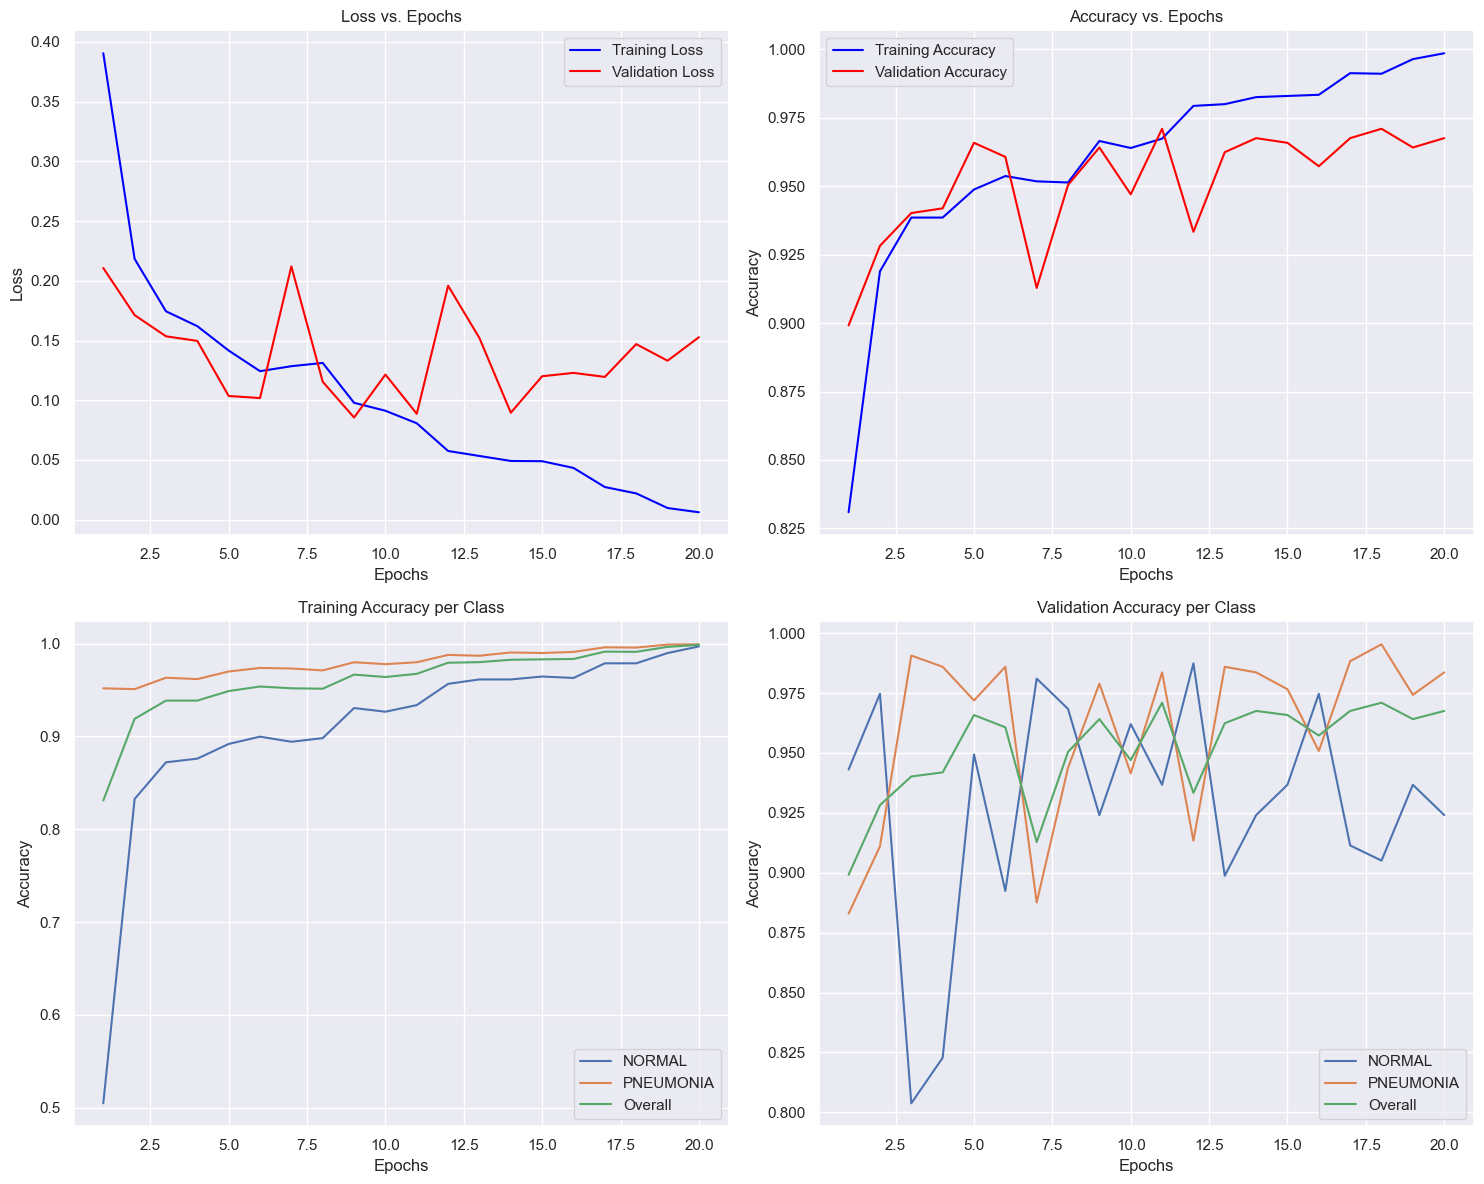

In [ ]:
# Initialize the model
model = SimpleModel().to(device)
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# Define loss function and optimizer
criterion_v2 = nn.CrossEntropyLoss()
optimizer_v2 = optim.SGD(
    model.parameters(),
    lr=0.01,              # Learning rate - start with 0.01
    momentum=0.9,         # Momentum - helps with faster convergence
    weight_decay=0.0001   # L2 regularization - helps prevent overfitting
)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

#Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, xray_train_loader, xray_val_loader, criterion_v2, optimizer_v2, NUM_EPOCHS, device, use_wandb
)
print(train_class_accuracies)
print(val_class_accuracies)
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')

print("Model saved as 'chest_xray_model.pth'")

**(a)**

_Insert brief explanation of the design choices you made_

__Response:__ I started with a basic CNN that we used for Lab 3. That is, a couple of 2D Kernels, flatenning, and then a couple of linear layers. The results in Lab 3, to me, were very impressive with this basic model. So I'm thinking this will be a good Baseline. Mostly because I know I will be building off a CNN anyways.

**(b)**

_Present your results, including plots etc. here_

![title](results/model_1.png)


**(c)**

_Discuss your results here_

**The first thing I notice is that my validation loss is starting to jump up after around 10 epochs. This strongly suggests overfitting. My validation accuracy also appears somewhat unstable at the beginning. But it evens out so I'm not too concerned.**

**In all honesty, the validation accuracy of 97% is hard to believe. How can it be that the model is performing this well at such an early stage? Sure, binary classification is an easy problem, but these chest xray images are difficult to interpret even as a human. See: https://www.radiologymasterclass.co.uk/gallery/chest/pulmonary-disease/tuberculosis_tb**

**Class accuracy appears unstable as well. But I can rectify this later with class weights.**


# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

In [19]:
"""Adding better metric calculations here. Because as it turns out, for class accuracies, if the model randomly guessed it would correctly predict 
PNEUMONIA 70% of the time due to class imbalance."""

def calculate_metrics(outputs: torch.tensor, labels: torch.tensor):
    _, predicted = torch.max(outputs, 1)
    
    # Calculate confusion matrix
    tp = ((predicted == 1) & (labels == 1)).sum().item()
    tn = ((predicted == 0) & (labels == 0)).sum().item()
    fp = ((predicted == 1) & (labels == 0)).sum().item()
    fn = ((predicted == 0) & (labels == 1)).sum().item()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall pneumonia
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall normal
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    return {
        'sensitivity': sensitivity,  # Also called recall
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1,
        'accuracy': (tp + tn) / (tp + tn + fp + fn)
    }

In [25]:
# Implement the improvements and train the model in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################


""" 1. Class Weights Adjustment:
I'll start with this. It is a relatively simple change and will likely have a big impact on the class accuracies.   
"""

total_samples = len(xray_train_dataset)
xray_train_dataset.summary()
class_samples = {
    'NORMAL': len(xray_train_dataset.images['NORMAL']),
    'PNEUMONIA': len(xray_train_dataset.images['PNEUMONIA'])
}

# Compute weights: less frequent classes get higher weights
orig_class_freq = torch.FloatTensor([
    total_samples / count for count in class_samples.values()
])
class_weights = torch.FloatTensor([
    total_samples / (2 * count) for count in class_samples.values()
]).to(device)

print(f"Original class frequency {orig_class_freq} \nInverse frequency class weights {class_weights}")
print(f"This means, that for NORMAL images, they are 3.7x more underrepresented in the dataset. So we adjust it to be 1.84x")

# Use weights in loss function later...
#criterion = nn.CrossEntropyLoss(weight=class_weights)


---- *train* Dataset Summary ----
Found 1266 NORMAL images
Found 3418 PNEUMONIA images
Found 4684 total images
              
Original class frequency tensor([3.6998, 1.3704]) 
Inverse frequency class weights tensor([1.8499, 0.6852], device='cuda:0')
This means, that for NORMAL images, they are 3.7x more underrepresented in the dataset. So we adjust it to be 1.84x


In [20]:

"""V2 Training methods"""

def train_epoch_v2(model: nn.Module,
                train_loader: DataLoader,
                criterion: _Loss,
                optimizer: Optimizer,
                device: str,
                epoch: int,
                num_epochs: int) -> Tuple[float, Dict[str, float]]:
    """Runs one epoch of training"""
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    
    # train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (labels, images) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # print(f"Epoch:{epoch}::Batch::{batch_idx} train loss: {loss.item()}")
        # Track metrics
        train_loss += loss.item()
        train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
        # train_pbar.set_postfix({'loss': loss.item()})
    
    epoch_avg_loss = train_loss / len(train_loader)
    epoch_accuracy = calculate_class_accuracy(
        torch.tensor(train_predictions), 
        torch.tensor(train_targets)
    )
    
    return epoch_avg_loss, epoch_accuracy

def validate_epoch_v2(model: nn.Module,
                  val_loader: DataLoader,
                  criterion: _Loss,
                  device: str,
                  scheduler,
                  epoch: int,
                  num_epochs: int) -> Tuple[float, Dict[str, float]]:
    """Runs one epoch of validation"""
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for batch_idx, (labels, images) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            
            all_outputs.append(outputs)
            all_labels.append(labels)
            # if epoch == 0 and batch_idx < 5:
            #     print(f"Epoch:{epoch}::Batch::{batch_idx} valid loss: {loss.item()}")
    
    """Metrics stuff"""
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    metrics = calculate_metrics(all_outputs, all_labels)
    epoch_val_loss = val_loss / len(val_loader)

    epoch_val_accuracy = calculate_class_accuracy(
        torch.tensor(val_predictions), 
        torch.tensor(val_targets)
    )
    """ +++ STEP SCHEDULER USING ReduceLRonPlateau +++ """
    scheduler.step(epoch_val_loss)
    
    return epoch_val_loss, epoch_val_accuracy, metrics

def train_model_v2(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion: _Loss,
                optimizer: Optimizer,
                scheduler,
                num_epochs: int = 1,
                device: str = 'cuda',
                use_wandb: bool = False) -> Tuple[List[float], List[float], List[float], List[float], List[Dict], List[Dict]]:
    """Main training loop that manages the training process"""
    
    print(f"-- Training Started::{model._get_name()} -- \n WANDB active::{use_wandb}")
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    train_class_accuracies, val_class_accuracies = [], []
    
    model_training_bar = tqdm(range(num_epochs), desc=f"Training {model._get_name()}")
    for epoch in model_training_bar:
        """Training"""
        epoch_avg_loss, epoch_accuracy = train_epoch_v2(
            model, train_loader, criterion, optimizer, device, epoch, num_epochs
        )
        train_losses.append(epoch_avg_loss)
        train_accuracies.append(epoch_accuracy['overall'])
        train_class_accuracies.append(epoch_accuracy)
        
        """Validation"""
        epoch_val_loss, epoch_val_accuracy, val_metrics = validate_epoch_v2(
            model, val_loader, criterion, device, scheduler, epoch, num_epochs
        )
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy['overall'])
        val_class_accuracies.append(epoch_val_accuracy)
        
        """Wandb stuff"""
        if use_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": epoch_avg_loss,
                "train_acc": epoch_accuracy['overall'],
                "train_normal_acc": epoch_accuracy['NORMAL'],
                "train_pneumonia_acc": epoch_accuracy['PNEUMONIA'],
                "val_loss": epoch_val_loss,
                "val_acc": epoch_val_accuracy['overall'],
                "val_normal_acc": epoch_val_accuracy['NORMAL'],
                "val_pneumonia_acc": epoch_val_accuracy['PNEUMONIA'],
                "val_sensitivity": val_metrics['sensitivity'],
                "val_specificity": val_metrics['specificity'],
                "val_precision": val_metrics['precision'],
                "val_f1": val_metrics['f1_score'],                
                "learning_rate": optimizer.param_groups[0]['lr']
            })
        model_training_bar.set_postfix({
            'train_loss': f'{epoch_avg_loss:.4f}',
            'train_acc': f'{epoch_accuracy["overall"]:.4f}',
            'val_loss': f'{epoch_val_loss:.4f}',
            'val_acc': f'{epoch_val_accuracy["overall"]:.4f}'
        })
        
    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies

In [21]:
CONV_DROPOUT_RATE = 0.7
FC_DROPOUT_RATE = 0.1 
LEARNING_RATE = 0.001
REDUCE_LR_FACTOR = 0.5
REDUCE_PATIENCE = 2
BATCH_SIZE = 64


# TODO Move all these params/constant somewhere, this is incredibly messy and it makes me want to kill myself.
run = wandb.init(project="chest-xray-classification",
                config={
                    "architecture": "CNN",
                    "dataset": "Chest X-Ray",
                    "learning_rate": LEARNING_RATE,
                    "epochs": NUM_EPOCHS,
                    "batch_size": BATCH_SIZE,
                    "optimizer": "SGD",
                    "conv_dropout": CONV_DROPOUT_RATE,
                    "fc_dropout": FC_DROPOUT_RATE,
                })

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rich-piana (rich-piana-ucl). Use `wandb login --relogin` to force relogin


In [22]:

""" 2. Dropout Regularization: """
class ModelV2(nn.Module):
    """Updated SimpleModel Architecture"""
    def __init__(self): 
        super().__init__()
        self.model = nn.Sequential(
            # First Conv Block
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(p=CONV_DROPOUT_RATE), 
            
            # Second Conv Block
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=CONV_DROPOUT_RATE),  # +++ Add dropout for deep layer +++
            
            nn.Flatten(),
            
            # Fully Connected Layers
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(p=FC_DROPOUT_RATE),  # +++ lower dropout for fully connnected layer +++
            
            nn.Linear(128, 2)  # No dropout after final layer
        )
        
    def forward(self, x):
        return self.model(x)
        

-- Training Started::ModelV2 -- 
 WANDB active::True


c:\Users\Gugu\Desktop\UCL\Deep_Learning\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training ModelV2:   0%|          | 0/20 [00:00<?, ?it/s]

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,█████████▃▃▃▃▃▃▃▃▃▁▁
train_acc,▁▆▆▆▆▇▇▇▇▇▇█████████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train_normal_acc,▁▅▆▆▆▆▇▇▇▇▇█▇▇▇█████
train_pneumonia_acc,▁▆▆▆▆▇▇▇▇▇██████████
val_acc,▄▂▂▇▃▁▅▅▂▇▅▅▆▇█▆▇▂▅▅
val_f1,▄▂▂▇▃▁▅▅▂▇▅▅▆▇█▆▇▂▅▅
val_loss,█▇▆▆▅▅▃▃▅▄▂▃▁▁▂▁▃▅▂▃
val_normal_acc,▃▆▅▁▅▇▅▆▇▄▅▅▅▅▅▅▅█▅▅
val_pneumonia_acc,▅▂▂█▄▁▅▅▂▇▅▅▆▆█▆▇▂▅▅


Model saved as 'chest_xray_model_v2.pth'


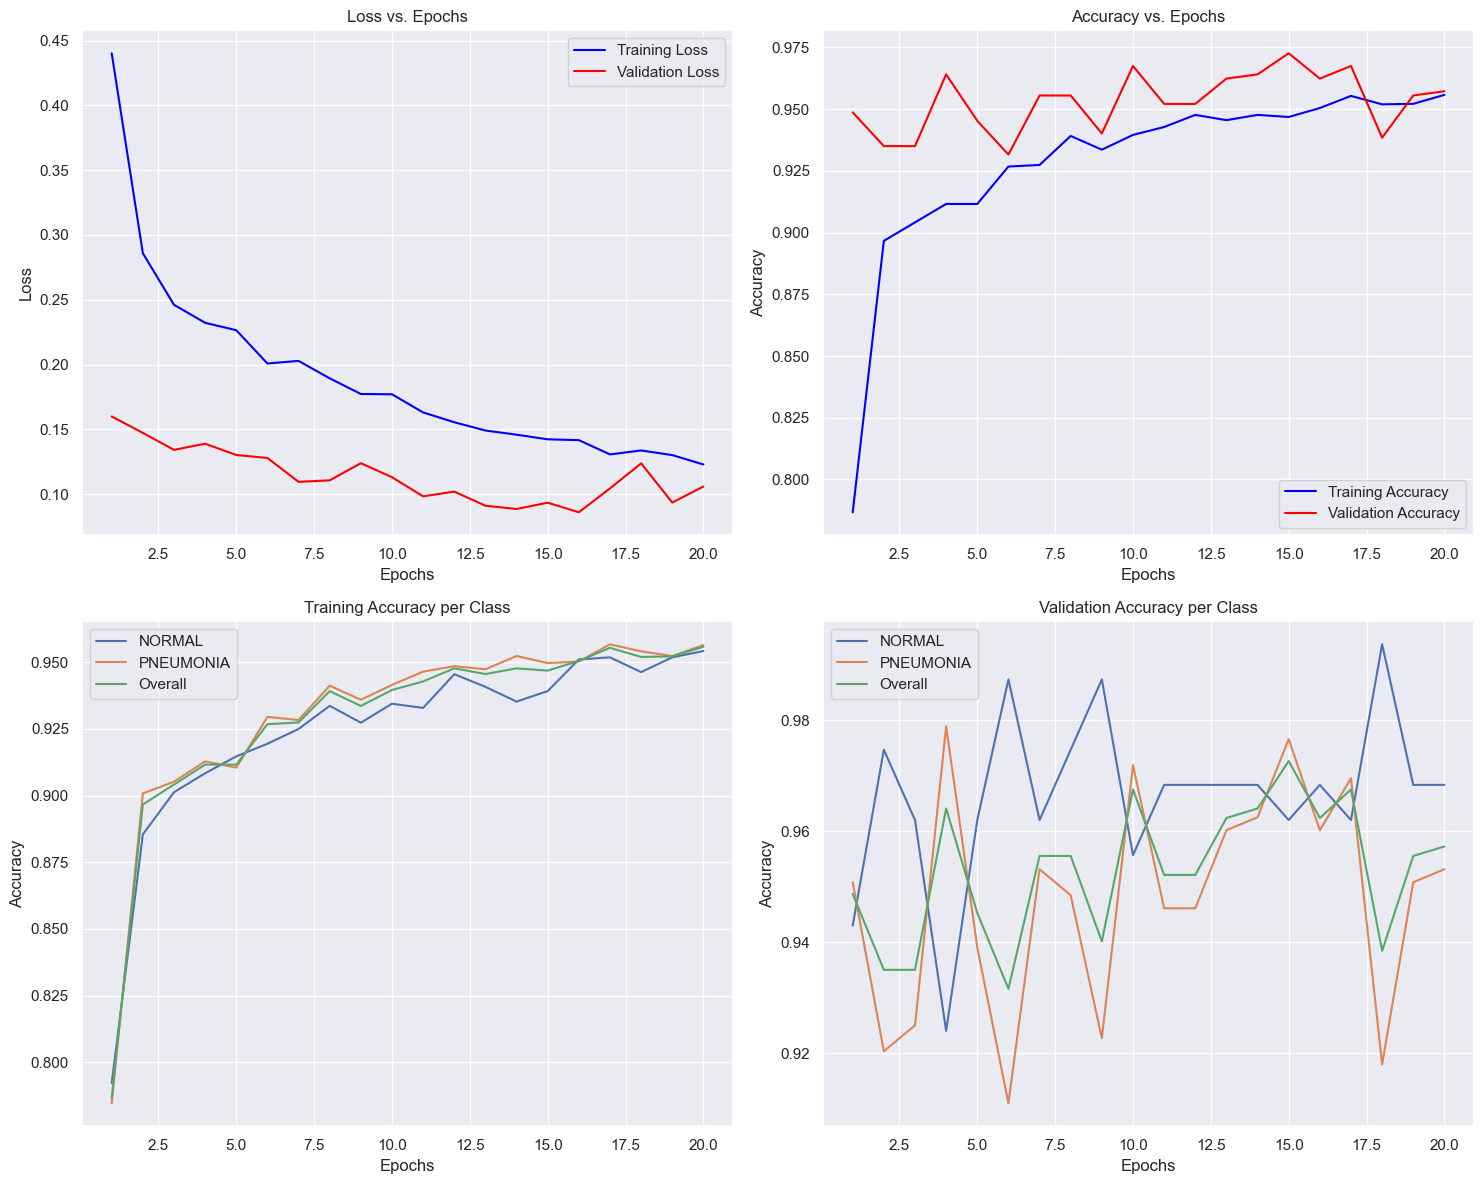

In [36]:
"""Train V2"""

# Initialize the model
model = ModelV2().to(device)
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# Define loss function and optimizer
criterion_v2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_v2 = optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0001   # TODO: maybe removing this L2 reg, since we are already doing dropout?
)

"""3. Learning Rate Scheduling

Using a factor of 0.1 here. So when it does plateau, it slows the LR by a factor of 10. i.e 0.01 * 0.1 = 0.001 """

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_v2,
    mode='min',
    factor=REDUCE_LR_FACTOR,
    patience=REDUCE_PATIENCE,
    verbose=True
)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

#Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model_v2(
    model, xray_train_loader, xray_val_loader, criterion_v2, optimizer_v2, scheduler,  NUM_EPOCHS, device, use_wandb
)
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model_v2.pth')
run.finish()
print("Model saved as 'chest_xray_model_v2.pth'")

**(a)**

1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*

<h3>Change #1 - Class Weights - Fixing Data Imbalance: </h3>

**Our Xray Dataset has a severe class imbalance. For example, if you were to randomly guess PNEUMONIA for every image, you would get 70% of your guesses right. This is due to the fact that our dataset is comprised of ~70% PNEUMONIA and ~30% NORMAL images. Which is obviously not ideal. So we can improve the loss and class accuracies for our model by simply adding weights to our classes. In our case, CrossEntropyLoss has a parameter** *w*  **which allows per class weights. We can reduce the potency of PNEUMONIA weight updates and increase NORMAL ones. Theoretically, this will improve our class accuracies and make for a more stable model. This is particularly important because Binary Classification is already a very easy task, so we want to get the best performance out of our model and not get confused by the already seemingly perfect accuracy.**  

<h3>Change #2 - Dropout for Regularization: </h3>

**From my reading, dropout is an excellent way to improve the generalization capability of the model. It has the side effect of creating a number of de facto ensemble models. Since, for each epoch we randomly kill nodes in our layers, with some probability, you are essentially creating several networks. This is superior to L2 Regularization. On top of creating an ensemble, it forces the model to not rely on a subset of nodes for prediction. This is similar to how L2 "shrinks" the weights of the model to prevent certain nodes from becoming dominant. But instead of shrinking, it zeroes them out completely. Theoretically, this will improve our validation loss and performance on unseen data.**

<h3>Change #3 - Learning Rate Scheduling: </h3>

**Originally, the model had a fixed learning rate of `0.001`. This means it was likely for the model to find a local minimum in the loss function rather than a global minimum. Using Pytorch's** `ReduceLRonPlateau` **learning rate scheduling method, we can decrease the learning rate given some metric, in my case, the validation loss. So if `patience=1`, and the val loss has not improved after one epoch, it will decrease the learning rate by a factor of `0.5`. This will be particularly useful given we have lots of overfitting. Theoretically, this will improve validation performance by gradually decreasing the loss function step size to find a better minimum.**


**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

<table>
<tr>
<td> **Baseline** SimpleModel Losses and Accuracies</td>
<td> **Improved** ModelV2 Losses and Accuracies </td>
<tr>
<td> train_loss=0.0062, train_acc=0.9985, val_loss=0.1527, val_acc=0.9675</td>
<td> train_loss=0.12283, train_acc=0.95581, val_loss=0.10585, val_acc=0.95726</td>
</tr>
  <tr>
    <td><img src="results/model_1.png" width="600"></td>
    <td><img src="results/model_v2_1.1.png" width="600"></td>
  </tr>
</table>

**(c)**

_Discuss your results here_

**On first glance, the statistics look rather dissapointing, aside from the validation loss, which has improved. The training loss, validation accuracy, and training accuracy have all been negatively effected. But this is because we have made the training much more difficult for the model. By introducing dropout the model is being forced to diversify and generalize. (I may have made my dropout somewhat more aggressive than it needs to be.) Note that the validation loss curve sits lower than the entire training loss curve, this is due to validation not having dropout, and is an easier inference.**

**Otherwise, the loss curves look more stable, and we have definitely eliminated the overfitting problem. The training class accuracies are also much more in line with what they should be, increasing gradually at the same rate. I have not fixed the validation class accuracy instability, but frankly I have no idea why they start so high anyways.**

**As such, these results are somewhat deceiving, when it comes to the test set, I think the improvements will be much more revealing.**

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


-- Training Started::ModelV2 -- 
 WANDB active::True


c:\Users\Gugu\Desktop\UCL\Deep_Learning\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training ModelV2:   0%|          | 0/20 [00:00<?, ?it/s]

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,███████▄▄▄▄▄▄▄▄▂▂▂▁▁
train_acc,▁▅▆▆▇▇▇▇▇▇▇█▇███████
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
train_normal_acc,▁▆▇▇▇▇▇▇████▇███████
train_pneumonia_acc,▁▁▂▃▄▅▅▅▅▆▆▇▇▇█▇████
val_acc,▁▃▅▇▇▇▇▇▆█▇██▇▇▇▄▆██
val_f1,▁▃▄▇▇▇▇▇▆█▇██▇▇▇▃▆██
val_loss,█▅▆▄▂▃▂▃▃▂▂▂▁▂▂▂▃▂▂▁
val_normal_acc,▅▅▇▄▂▁▁▇▇▆▅▆▅▆▆▇█▆▆▅
val_pneumonia_acc,▁▂▂▇▇██▅▄▆▆▆▇▅▅▅▁▅▆▆


Model saved as 'chest_xray_model_v2_rm_class_weights.pth'


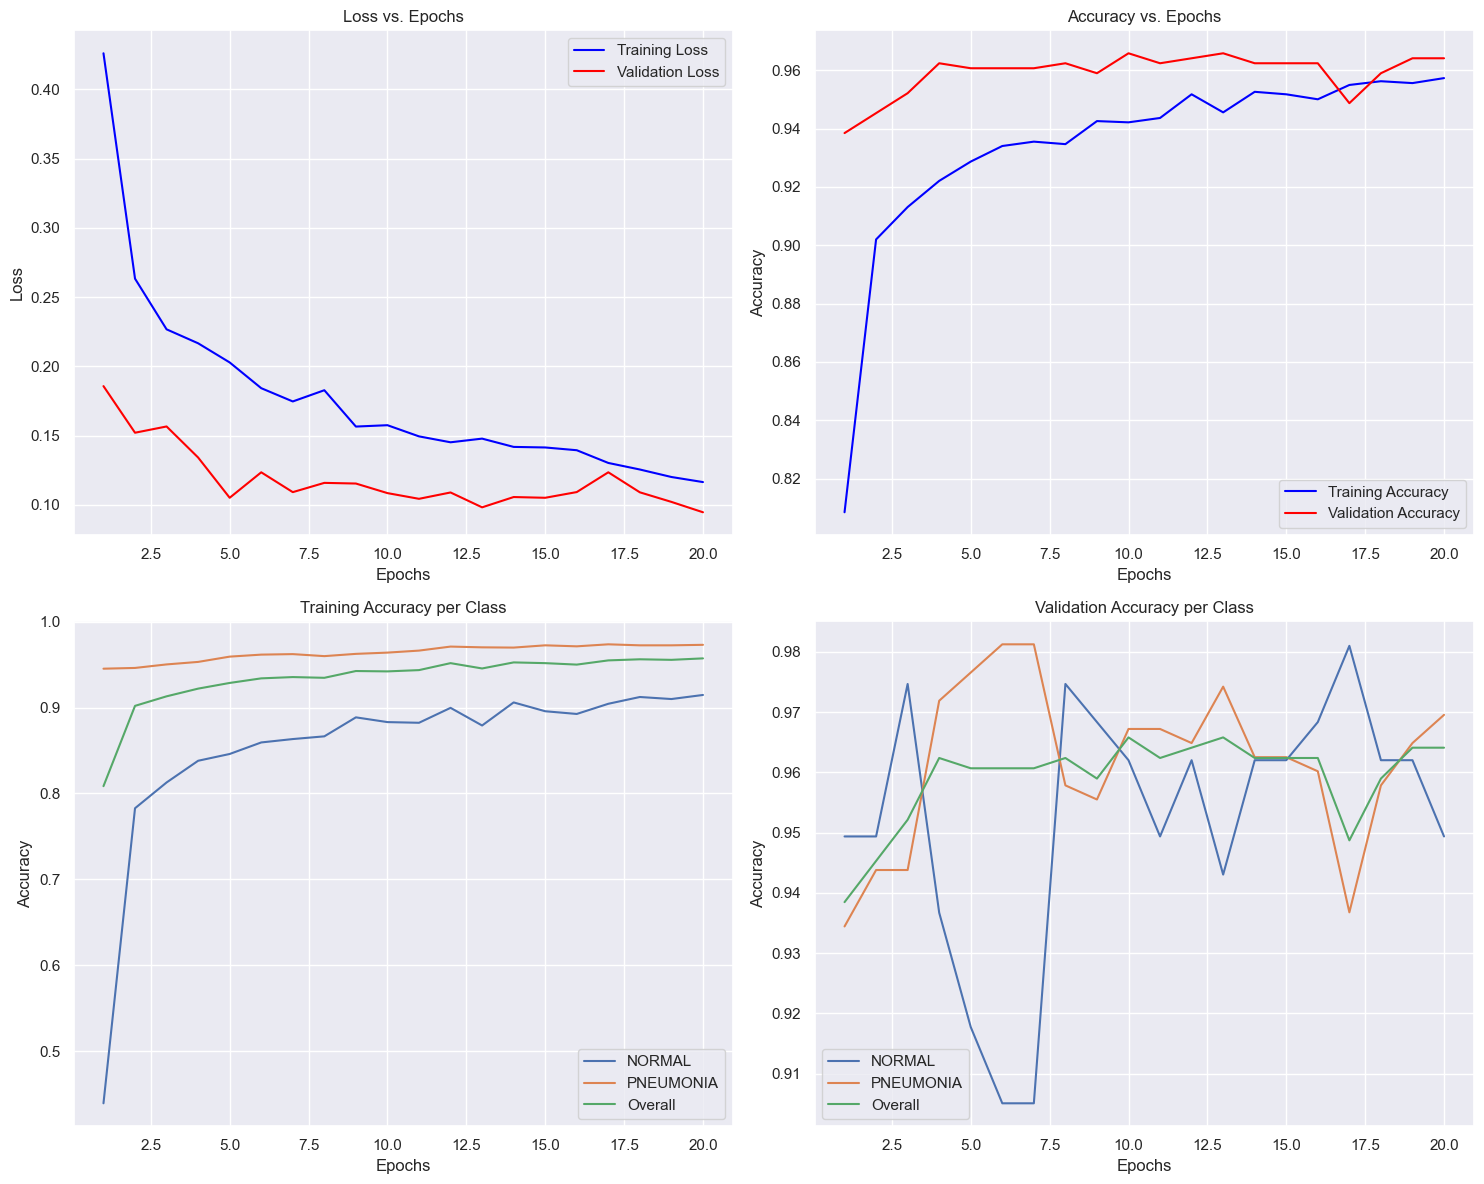

In [ ]:
# Implement the experiment in as many cells as you need.
"""TRAIN WITHOUT CLASS WEIGHTS"""
model = ModelV2().to(device)

""" -- REMOVING CLASS WEIGHTS ---"""
criterion_v2 = nn.CrossEntropyLoss() #weight=class_weights)
optimizer_v2 = optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0001 
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_v2,
    mode='min',
    factor=REDUCE_LR_FACTOR,
    patience=REDUCE_PATIENCE,
    verbose=True
)

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model_v2(
    model, xray_train_loader, xray_val_loader, criterion_v2, optimizer_v2, scheduler,  NUM_EPOCHS, device, use_wandb
)
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

torch.save(model.state_dict(), 'chest_xray_model_v2_rm_class_weights.pth')
run.finish()
print("Model saved as 'chest_xray_model_v2_rm_class_weights.pth'")

**(a)**

_State the improvement you are justifying_

**I would like to mention that it is incredibly frustrating to undo changes to my model architecture just to see the results.**
**This could have been mentioned earlier instead of making me write all three changes at the beginning**

<H3>Change #1: Class Weights Empirical Justification

**(b)**

_Present your results, including plots etc, here_

<img src="results/model_v2_1.1_no_class_weights.png" width="800">

**train_loss=0.1165, train_acc=0.9573, val_loss=0.0947, val_acc=0.9641**

**(c)**

_Discuss your results here_

**As expected our training class accuracies are not in sync. Also the instability in the class validations has skyrocketed. Further illustrating the importance of having balanced classes. Also, our overall accuracies and losses have improved, but this is deceiving, because we've made the prediction task easier. As such, class weights are important.** 

## Q 4.3: Empirically justify improvement 2 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

"""REMOVING DROPOUT REGULARIZATION"""
"""ADD CLASS WEIGHTS AGAIN"""

"""All we have to do is set the probabilities of dropping nodes to zero."""
CONV_DROPOUT_RATE = 0
FC_DROPOUT_RATE = 0

run = wandb.init(project="chest-xray-classification",
                config={
                    "architecture": "CNN",
                    "dataset": "Chest X-Ray",
                    "learning_rate": LEARNING_RATE,
                    "epochs": NUM_EPOCHS,
                    "batch_size": BATCH_SIZE,
                    "optimizer": "SGD",
                    "conv_dropout": CONV_DROPOUT_RATE,
                    "fc_dropout": FC_DROPOUT_RATE,
                })

"""We have to redefine the model instance"""
model = ModelV2().to(device)

criterion_v2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_v2 = optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0001 
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_v2,
    mode='min',
    factor=REDUCE_LR_FACTOR,
    patience=REDUCE_PATIENCE,
    verbose=True
)

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model_v2(
    model, xray_train_loader, xray_val_loader, criterion_v2, optimizer_v2, scheduler,  NUM_EPOCHS, device, use_wandb
)
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

torch.save(model.state_dict(), 'chest_xray_model_v2_1.1_no_dropout.pth')
run.finish()
print("Model saved as 'chest_xray_model_v2_1.1_no_dropout'")


-- Training Started::ModelV2 -- 
 WANDB active::True


c:\Users\Gugu\Desktop\UCL\Deep_Learning\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training ModelV2:   0%|          | 0/20 [00:00<?, ?it/s]

**(a)**

_State the improvement you are justifying_

<h3>Change #2 - Dropout for Regularization </h3>

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

## Q 4.4: Empirically justify improvement 3 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [ ]:
def evaluate_test_set(model: nn.Module,
                     test_loader: DataLoader,
                     criterion: _Loss,
                     device: str):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for labels, images in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            all_outputs.append(outputs)
            all_labels.append(labels)
    
    """Metrics Stuff"""
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    metrics = calculate_metrics(all_outputs, all_labels)
    test_loss = test_loss / len(test_loader)
    
    print("\nTest Set Results:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Sensitivity (Pneumonia Recall): {metrics['sensitivity']:.4f}")
    print(f"Specificity (Normal Recall): {metrics['specificity']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    
    return test_loss, metrics


In [ ]:
# Implement evaluation here
"""Model V1 Final Test"""

model = SimpleModel().to(device)
criterion_v1 = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('chest_xray_model.pth'))

"""Model V2 Final Test"""

model = ModelV2().to(device)
criterion_v2 = nn.CrossEntropyLoss(weight=class_weights)
model.load_state_dict(torch.load('chest_xray_model_v2.pth'))

#TODO fix this torch.load() warning. 
test_loss, test_metrics = evaluate_test_set(model, xray_test_loader, criterion_v2, device)

C:\Users\Gugu\AppData\Local\Temp\ipykernel_5480\3940012513.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('chest_xray_model_v2.pth'))



Test Set Results:
Loss: 0.1868
Accuracy: 0.9421
Sensitivity (Pneumonia Recall): 0.9416
Specificity (Normal Recall): 0.9434
Precision: 0.9782
F1 Score: 0.9595


**(a)**

_Present your results, including plots etc, here_

**(b)**

_Discuss your results here_